In [22]:
import pandas as pd
import numpy as np
from fastkml import kml
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load the KML file
file_path = r"C:\Users\britt\Artefact2\TrafficVolumeEstimates_kml\TrafficVolumeEstimates_GDA94.kml"

def parse_kml(file_path):
    with open(file_path, 'rt', encoding='utf-8') as f:
        doc = f.read()
    k = kml.KML()
    k.from_string(doc)
    
    # Assuming the KML contains features inside folders
    traffic_data = []
    features = list(k.features())
    
    for feature in features:
        for sub_feature in feature.features():
            for placemark in sub_feature.features():
                name = placemark.name
                description = placemark.description
                geometry = placemark.geometry  # This might contain lat/long data if available
                # Add relevant extracted data
                traffic_data.append({
                    'name': name,
                    'description': description,
                    'geometry': geometry
                })
    
    # Return as DataFrame
    return pd.DataFrame(traffic_data)



In [23]:
# Step 2: Parse KML and create DataFrame
df = parse_kml(file_path)
print(df.head())  # Inspect the structure of the parsed data

# Assuming `description` contains traffic volume and time-related information
# You might need to adjust this based on your actual data
# Create a sample DataFrame with `timestamp` and `traffic_volume` columns for demonstration purposes
df['timestamp'] = pd.date_range(start='2024-01-01', periods=len(df), freq='H')  # Dummy timestamps
df['traffic_volume'] = np.random.randint(100, 5000, size=(len(df),))  # Dummy traffic volume data


   name description                                           geometry
0  None        None  MULTILINESTRING((139.056150989 -34.767450845, ...
1  None        None  MULTILINESTRING((140.043858248 -37.447808927, ...
2  None        None  MULTILINESTRING((139.338155743 -35.68798987699...
3  None        None  MULTILINESTRING((138.575908236 -35.005922042, ...
4  None        None  MULTILINESTRING((138.558030171 -35.00632880099...


C:\Users\britt\AppData\Local\Temp\ipykernel_14524\2920303871.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['timestamp'] = pd.date_range(start='2024-01-01', periods=len(df), freq='H')  # Dummy timestamps


In [24]:
# Step 3: Data Preprocessing
df['timestamp'] = pd.to_datetime(df['timestamp'])  # Ensure timestamp is datetime
df = df.set_index('timestamp')
df = df.asfreq('1min')  # Resample to 1-minute intervals

# Fill missing values if needed
df['traffic_volume'] = df['traffic_volume'].interpolate()

# Feature Engineering
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek



In [25]:
# Step 4: Train-test split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['traffic_volume']])
test_scaled = scaler.transform(test[['traffic_volume']])



In [26]:
# Step 5: Prepare data for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60  # Predict using the last 60 minutes
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))



In [27]:
# Step 6: Build LSTM Model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')



C:\Users\britt\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
# Step 7: Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))



Epoch 1/20
4031/4031 ━━━━━━━━━━━━━━━━━━━━ 245s 59ms/step - loss: 0.0029 - val_loss: 2.0241e-04
Epoch 2/20
4031/4031 ━━━━━━━━━━━━━━━━━━━━ 235s 58ms/step - loss: 2.3587e-04 - val_loss: 0.0010
Epoch 3/20
4031/4031 ━━━━━━━━━━━━━━━━━━━━ 285s 71ms/step - loss: 1.5719e-04 - val_loss: 0.0029
Epoch 4/20
4031/4031 ━━━━━━━━━━━━━━━━━━━━ 238s 59ms/step - loss: 1.0606e-04 - val_loss: 0.0032
Epoch 5/20
4031/4031 ━━━━━━━━━━━━━━━━━━━━ 280s 69ms/step - loss: 7.6670e-05 - val_loss: 0.0045
Epoch 6/20
4031/4031 ━━━━━━━━━━━━━━━━━━━━ 242s 60ms/step - loss: 6.4839e-05 - val_loss: 0.0051
Epoch 7/20
4031/4031 ━━━━━━━━━━━━━━━━━━━━ 241s 60ms/step - loss: 5.7809e-05 - val_loss: 0.0042
Epoch 8/20
4031/4031 ━━━━━━━━━━━━━━━━━━━━ 246s 61ms/step - loss: 5.0663e-05 - val_loss: 0.0049
Epoch 9/20
4031/4031 ━━━━━━━━━━━━━━━━━━━━ 238s 59ms/step - loss: 4.5585e-05 - val_loss: 0.0050
Epoch 10/20
4031/4031 ━━━━━━━━━━━━━━━━━━━━ 236s 59ms/step - loss: 4.5402e-05 - val_loss: 0.0043
Epoch 11/20
4031/4031 ━━━━━━━━━━━━━━━━━━━━ 238s 5

1007/1007 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step
RMSE: 314.85827904995097, MAE: 264.8347849884697


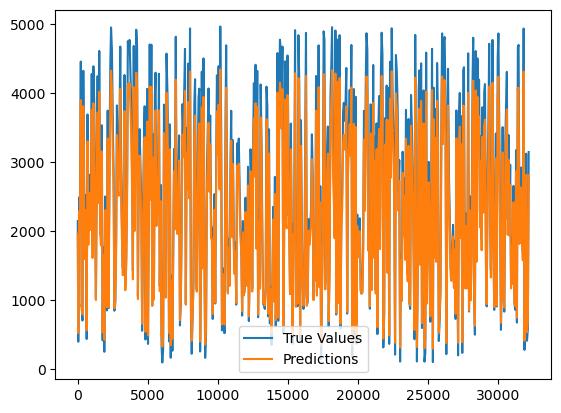

In [29]:
# Step 8: Evaluate the Model
predicted = model.predict(X_test)

# Inverse scaling to get original values
predicted_inverse = scaler.inverse_transform(predicted)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_test_inverse, predicted_inverse))
mae = mean_absolute_error(y_test_inverse, predicted_inverse)

print(f'RMSE: {rmse}, MAE: {mae}')

# Plot results
plt.plot(y_test_inverse, label='True Values')
plt.plot(predicted_inverse, label='Predictions')
plt.legend()
plt.show()



In [30]:
# Step 9: Save the Model
model.save('traffic_volume_model.h5')
